# Statistical Experiments and Significance Testing

The goal is to design an experiment in order to confirm or reject a hypothesis. Data Scientist often conducts continual experiments, particularly regarding user interface and product marketing.

## A/B Testing
Important key terms: 
- **Treatment**
- **Treatment group**
- **Control group**
- **Randomization**
- **Subjects**
- **Test statistic**

Data Scientist are less interested in the question:
- It the difference between price A and price B statistically significant?
than in the question:
- Which, out of multiple possible prices, is best?

For this, a relatively new type of experimental design is used: **the multi-arm bandit**

## Hypothesis Tests
Important key terms: 
- **Null hypothesis**
- **Alternative hypothesis**
- **One-way test**
- **Two-way test**

An A/B test is typically constructed with a hypothesis in mind. Why not just look at the outcome of the experiment and go with whichever treatment does better? 
- Failure to anticipate extreme events
- Misinterpret random events as having patterns of some significance. 

Recall the misinterpretation of randomness (50 written coin tosses vs. 50 real coin tosses)

Note that one-tial vs. two-tail is a confusing subject, and not that relevant to data science, where the percision of p-value calculations is not terribly important.

## Resampling
Important key terms: 
- **Permutation test** (for visualization: https://www.jwilber.me/permutationtest/)
- **Resampling**
- **With or without replacement**

## Example: Web Stickiness

Using a proxy variable a company decides to measure which two presentations does a better job selling this relatively high-value service. One potential proxy variable for our company is the number of clicks on the detailed landing page. A better on is how long people spend on the page (average session time), comparing page A to page B.
 
Note: Google Analytics cannot measure session time for the last session a person visits so it records it as a zero. Additional processiong to remove those sessions is required.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from pathlib import Path
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power


%matplotlib inline

In [3]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [4]:
WEB_PAGE_DATA_CSV = DATA / 'web_page_data.csv'
FOUR_SESSIONS_CSV = DATA / 'four_sessions.csv'
CLICK_RATE_CSV = DATA / 'click_rates.csv'
IMANISHI_CSV = DATA / 'imanishi_data.csv'

In [6]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.head()

,Page,Time
0,Page A,0.21
1,Page B,2.53
2,Page A,0.35
3,Page B,0.71
4,Page A,0.67


In [7]:
session_times.Time = 100*session_times.Time 

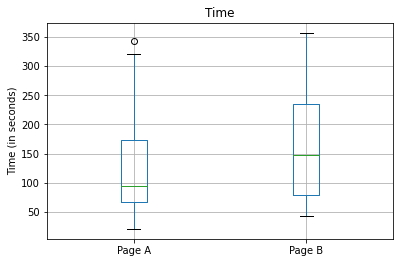

In [10]:
ax = session_times.boxplot(by='Page', column='Time')
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.show()

Note: page B leads to longer sessions than page A.

In [11]:
mean_a = session_times[session_times['Page'] == 'Page A']['Time'].mean()
mean_b = session_times[session_times['Page'] == 'Page B']['Time'].mean()
mean_b-mean_a

35.66666666666667

Page B has session times that are greater than those of page A by 35.67 seconds, on average. The question is whethe this difference is within the range of what random chance might produce, i.e. is statistically significant. One way to answer this is with a permutation test

In [12]:
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()

In [21]:
session_times['Page'].value_counts()

Page A    21
Page B    15
Name: Page, dtype: int64

In [22]:
nA = session_times[session_times['Page'] == 'Page A'].shape[0]
nB  = session_times[session_times['Page'] == 'Page B'].shape[0]
print(nA, nB)
print(perm_fun(session_times.Time, nA, nB))

21 15
-1.1333333333333258


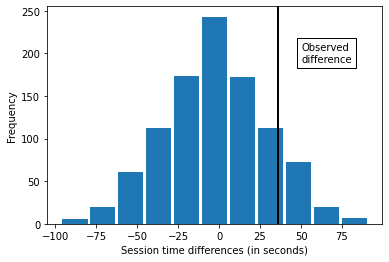

In [24]:
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots()
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=mean_b-mean_a, color='black', lw=2)
ax.text(50,190, 'Observed\ndifference', bbox={'facecolor': 'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')
plt.show()

The histogram shows that mean difference of random permutations often exceed the observed difference in session times. This happens approx. 12% of the time.

In [26]:
np.mean(perm_diffs > mean_b - mean_a)

0.119

Thus the observed difference in session time between page A and page B is well within the range of chance variation and thus is not statistically significant.

## Statistical Significance and p-Values
Important key terms: 
- **p-value** (probability of obtaining results as unusual or extreme as the observed results)
- **Alpha**
- **Type 1 error**
- **Type 2 error**

### Table for ecommerce experiment results

|Outcome|Price A|Price B|
|---|---|---|
|Conversion|200|182|
|No Conversion|23,539|22,406|

Price A converts almost 5% better than price B. Note that it's tempting to consider this 'big data' with 45000 data points (significance testing is needed only to account for sampling variability in small samples) but the value of interest only has hundreds of data points. So we can ask if the two prices share the same conversion rate, could chance variation produce a difference as big as 5%?

Observed difference: 0.0368%


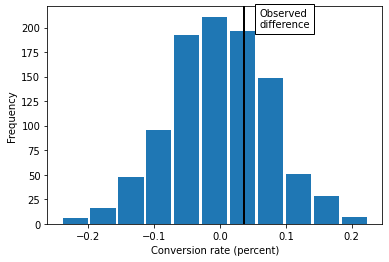

In [31]:
obs_pct_diff = 100*(200/(23539+200)-182/(22406+182))
print('Observed difference: {:.4f}%'.format(obs_pct_diff))
conversion = [0]*(23593+22406)
conversion.extend([1]*(200+182))
conversion = pd.Series(conversion)

perm_diffs = [100*perm_fun(conversion, 23539+200, 22406+182) for _ in range(1000)]
fig, ax = plt.subplots()
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(.06,200, 'Observed\ndifference', bbox={'facecolor': 'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')
plt.show()

In [33]:
# p-value
np.mean([diff > obs_pct_diff for diff in perm_diffs])

0.304

Note that we didn't need to use a permutation test to get a p-value. We have binomial distribution, we can approximate the p-value

In [45]:
survivors = np.array([[200, 23593], [182, 22406]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)
print('p-value for single sided test: {:.4f}'.format(p_value/2))

p-value for single sided test: 0.3581


What the p-value actully represents is: given a chance model, results as extreme as the observed result could occur. Significance tests are typically structured to minimize Type 1 errors. For Data Science p-value is a decision tool in an experiment, merely another point of information bearing on a decision. For example, p-values are sometimes used as intermediate inputs in some statisitcal or machine learning models - a feature might be included in or excluded from a model depending on its p-value.